In [23]:
import sys
import pandas as pd
sys.path.insert(0, '../Moduulit')
pd.options.mode.chained_assignment = None

# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *
from reittien_erottelu import *
from sisään_uloskäynnit import *
from clean_velocities import *
# tai from ... import *

In [24]:
%%time

df = database_query("SELECT * FROM SensorData limit 1000000")
df.head()

CPU times: user 15.4 s, sys: 1.51 s, total: 16.9 s
Wall time: 16.9 s


,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0


In [25]:
df = df.sort_values(by=['node_id', 'timestamp'])


### Datan siivous

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 5161
uniques in y 5033
uniques in z 1
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 3
------------------------------
Outliers

Data with outliers:  1000000
Ouliers removed:     6483
Data after:  993517
CPU times: user 15.8 s, sys: 208 ms, total: 16 s
Wall time: 16 s


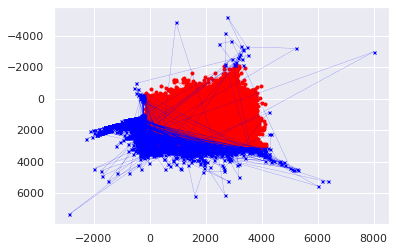

In [26]:
%%time
df = find_outliers(df)
df = clean_dataframe(df)

In [27]:
df

,node_id,timestamp,x,y,dayofweek,current_hour
0,1,2020-06-24 15:20:08.533,2762,-257,2,8
1,1,2020-06-24 15:20:08.620,2870,-344,2,8
2,1,2020-06-24 15:20:09.623,2916,-344,2,8
3,1,2020-06-24 15:20:09.623,2894,-254,2,8
4,1,2020-06-24 15:20:10.116,2888,-188,2,8
...,...,...,...,...,...,...
932744,3,2020-08-16 12:08:11.426,1938,-267,6,3
932745,3,2020-08-16 12:08:20.426,1922,-242,6,3
932746,3,2020-08-16 12:08:39.426,2002,-332,6,3
932747,3,2020-08-16 12:09:16.426,1961,-281,6,3


### Diskretisoidaan data

In [29]:
%%time
grid_size = 30
df = xy_to_grid(df, df.x, df.y, grid_size)
df

CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 46.5 ms


,node_id,timestamp,x,y,dayofweek,current_hour,x_grid,y_grid,grid_id
0,1,2020-06-24 15:20:08.533,2762,-257,2,8,20,10,320
1,1,2020-06-24 15:20:08.620,2870,-344,2,8,21,9,291
2,1,2020-06-24 15:20:09.623,2916,-344,2,8,21,9,291
3,1,2020-06-24 15:20:09.623,2894,-254,2,8,21,10,321
4,1,2020-06-24 15:20:10.116,2888,-188,2,8,21,10,321
...,...,...,...,...,...,...,...,...,...
932744,3,2020-08-16 12:08:11.426,1938,-267,6,3,14,10,314
932745,3,2020-08-16 12:08:20.426,1922,-242,6,3,14,10,314
932746,3,2020-08-16 12:08:39.426,2002,-332,6,3,15,10,315
932747,3,2020-08-16 12:09:16.426,1961,-281,6,3,14,10,314


### Etsitään sisään- ja uloskäynnit. Muokataan ne myös ID-muotoon

In [30]:
%%time
in_x, in_y = sisään(df, "x_grid", "y_grid")
out_x, out_y = ulos(df, "x_grid", "y_grid")

in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# draw_exits(df1, in_x, in_y, out_x, out_y)

CPU times: user 440 ms, sys: 3.96 ms, total: 444 ms
Wall time: 442 ms


### Erotellaan yksittäiset reitit

In [31]:
%%time
# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()

reitit = erottele_reitit(df, u_in_ID, u_out_ID)

reitit = poista_lyhyet_reitit(reitit, grid_size)
df = reitit_dataframeksi(reitit)


CPU times: user 3.83 s, sys: 0 ns, total: 3.83 s
Wall time: 3.83 s


In [37]:
# poistetaan kassa- ja sisääntuloalueella olevat datapisteet
df = df[~df["grid_id"].isin(u_in_ID)]
df = df[~df["grid_id"].isin(u_out_ID)]

df = df[df["ajokerta"]!= 8806]

# poistetaan yli kaksi tuntie kestävät reissut
# df["kesto"] = df["kesto"].dt.total_seconds()
# df = df[df["kesto"] < 7200]
# df = df[df["kesto"] > 0]
# plot_unique_routes(df, grid_size, in_x, in_y, out_x, out_y)  

df

,ajokerta,node_id,timestamp,x,y,grid_id,kesto
1,1,1,2020-06-25 15:21:44.647,21,11,351,805.000
2,1,1,2020-06-25 15:21:45.646,21,11,351,805.000
3,1,1,2020-06-25 15:21:46.646,21,12,381,805.000
4,1,1,2020-06-25 15:21:47.645,20,12,380,805.000
5,1,1,2020-06-25 15:21:47.645,20,12,380,805.000
...,...,...,...,...,...,...,...
447,119,3,2020-08-12 12:43:13.601,10,11,340,926.999
451,119,3,2020-08-12 12:43:16.601,10,11,340,926.999
452,119,3,2020-08-12 12:43:18.601,10,11,340,926.999
453,119,3,2020-08-12 12:43:19.602,10,11,340,926.999


In [4]:
from write_df_to_database import write_df_to_mariadb

In [15]:
write_df_to_mariadb(df, "ASDDB")

Existing table found. Prepairing to Drop Table named ASDDB...


Continue? yes/no:  yes


Done! Prepairing to write dataframe to ASDDB
Writing data 1 / 22
Writing data 2 / 22
Writing data 3 / 22
Writing data 4 / 22
Writing data 5 / 22
Writing data 6 / 22
Writing data 7 / 22
Writing data 8 / 22
Writing data 9 / 22
Writing data 10 / 22
Writing data 11 / 22
Writing data 12 / 22
Writing data 13 / 22
Writing data 14 / 22
Writing data 15 / 22
Writing data 16 / 22
Writing data 17 / 22
Writing data 18 / 22
Writing data 19 / 22
Writing data 20 / 22
Writing data 21 / 22
Writing data 22 / 22
Done!
